<a href="https://colab.research.google.com/github/yohanesnuwara/pyreservoir/blob/master/notebooks/aquifer_influx_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!git clone https://github.com/yohanesnuwara/pyreservoir

Cloning into 'pyreservoir'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 616 (delta 81), reused 0 (delta 0), pack-reused 460
Receiving objects: 100% (616/616), 1.41 MiB | 1.07 MiB/s, done.
Resolving deltas: 100% (323/323), done.


In [3]:
import sys
sys.path.append('/content/pyreservoir/matbal')

from aquifer import schilthuis, veh, fetkovich

In [5]:
"""""""""""
INPUT
"""""""""""

# reservoir rock and fluid properties
Nfoi = 48.75 # OOIP, in MMSTB (million STB)
Boi = 1.078 # Initial oil FVF, in RB/STB
Bob = 1.094 # Oil FVF at bubble-point pressure, in RB/STB
Bw = 1.02 # Water FVF, in RB/STB
swi = 0.48 # Initial water saturation
cf = 4E-06 # Formation compressibility, in psi^-1
cw = 3E-06 # Water compressibility, in psi^-1
poro = 0.177 # Porosity
perm = 432 # Permeability, in md
mu_w = 0.38 # Water viscosity, in cp

# reservoir and aquifer dimension
h = 31.8 # reservoir thicknes, ft
vbulk = 73590 # reservoir bulk volume, acre ft
r_R = 5664.5 # Reservoir radius, in ft
r_aq = 275000 # Aquifer radius, in ft
h_aq = 71.73 # Aquifer thickness, in ft
theta = 360 # reservoir is cylindrical (full circle)

data_path = '/content/pyreservoir/data/Production_Data_Moonie_Field.csv'

# conversion
Nfoi = Nfoi * 1E+06 # convert from MMSTB to STB

"""""""""""
CALCULATION
"""""""""""

# load data
data = pd.read_csv(data_path)

# convert time column to DateTime format (check: https://strftime.org/)
# time data in format: 01 January 1964
data['t'] = pd.to_datetime(data['t'], format='%d %B %Y')

datetime = data['t'].values
pressure = data['p'].values

## Schilthuis Method

In [6]:
method1 = schilthuis()

# Calculate water influx using Schilthuis function
Np = np.array(data['Np'])
Wp = np.array(data['Wp'])
Bo = np.array(data['Bo'])

We_schilthuis = schilthuis.calculate_aquifer(method1, pressure, Bw, Wp, Np, Bo, Nfoi, cf, cw, swi, Boi)

## Van Everdingen-Hurst Method

In [7]:
method2 = veh()

# calculate aquifer constant
# there are 2 ways: 1. Using "calculate_aquifer_constant" functon, 2. Using MBAL
B = 3191.2 # Aquifer constant, from material balance

# Calculate water influx using VEH method
We_veh = veh.calculate_aquifer(method2, datetime, pressure, cf, cw, perm, poro, mu_w, r_R, B)

## Fetkovich

In [8]:
method3 = fetkovich()

# calculate initial encroachable water, Wei
pi = data['p'].iloc[0]
ct = cf + cw
Wei = fetkovich.initial_encroachable_water(method3, pi, ct, r_R, r_aq, h_aq, poro, theta)

# calculate productivity index
# flowing aquifer
J = fetkovich.productivity_index(method3, perm, h_aq, mu_w, r_aq, r_R, theta, flow='no flow')

# Calculate water influx using Fetkovich function
We_fetkovich = fetkovich.calculate_aquifer(method3, datetime, pressure, Wei, J)


## Plot result using all methods

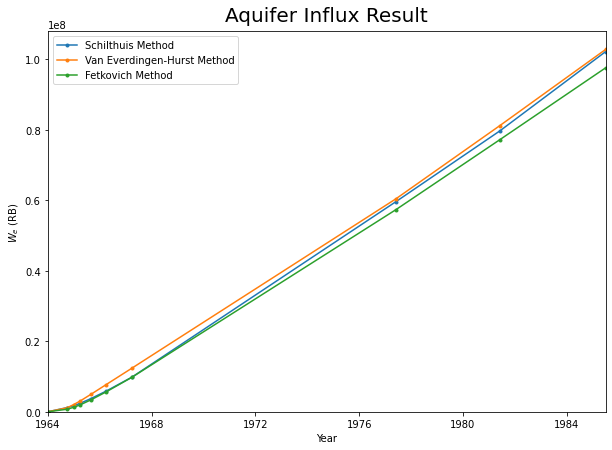

In [12]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(10,7))

plt.plot(datetime, We_schilthuis, '.-', label='Schilthuis Method')
plt.plot(datetime, We_veh, '.-', label='Van Everdingen-Hurst Method')
plt.plot(datetime, We_fetkovich, '.-', label='Fetkovich Method')
plt.title('Aquifer Influx Result', size=20, pad=10)
plt.xlabel('Year'); plt.ylabel('$W_e$ (RB)')
plt.xlim(np.min(datetime), np.max(datetime))
plt.ylim(ymin=0)
plt.legend()
plt.show()